In [1]:
import networkx as nx
import numpy as np
import scipy as sp
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities
import pandas as pd
from tqdm import tqdm

G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str)
print(f"number of nodes in original dataset: ", len(G0.nodes))

#removing the prefix in proteins
protein_info = pd.read_csv("Protein_info.txt", sep='\t')
map_dic = protein_info.set_index('#string_protein_id').to_dict()['preferred_name']
   
G = nx.relabel_nodes(G0, map_dic)

# remove essential proteins
essential_proteins = pd.read_csv("yeast essential proteins.csv", header=None)[1]
print()
print(essential_proteins)
G.remove_nodes_from(essential_proteins)
print(f"number of nodes after removing essential proteins: ", len(G.nodes))  

# delete those edges with a combined score of <= threshold_score (small confidence)
threshold_score = 500
for edge in G.edges: 
    weight = list(G.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G.remove_edge(edge[0],edge[1])
print("Number of edges after filtering over low score", len(G.edges))

number of nodes in original dataset:  6394

0         YAL001C
1         YAL003W
2         YAL012W
3         YAL025C
4         YAL032C
          ...    
1308    YKL138C-A
1309    YNL138W-A
1310    YNL024C-A
1311    YHR199C-A
1312    YIL102C-A
Name: 1, Length: 1313, dtype: object
number of nodes after removing essential proteins:  6324
Number of edges after filtering over low score 209613


## Find the shortest paths between each pair of nodes

In [18]:
import itertools

# proteins = ['YER178W', 'YBR221C', 'YNL071W', 'YFL018C', 'YOR090C', 'YIL042C', 'YGL059W']

proteins = ['PDA1', 'PDB1', 'LAT1', 'LPD1', 'PKP1', 'PKP2', 'PTC5']

for n1, n2 in itertools.combinations(proteins, 2):
    print(nx.shortest_path(G, source=n1, target=n2))

['PDA1', 'PDB1']
['PDA1', 'LAT1']
['PDA1', 'LPD1']
['PDA1', 'PKP1']
['PDA1', 'PKP2']
['PDA1', 'PTC5']
['PDB1', 'LAT1']
['PDB1', 'LPD1']
['PDB1', 'PKP1']
['PDB1', 'PKP2']
['PDB1', 'PTC5']
['LAT1', 'LPD1']
['LAT1', 'PKP1']
['LAT1', 'PKP2']
['LAT1', 'PTC5']
['LPD1', 'LAT1', 'PKP1']
['LPD1', 'LAT1', 'PKP2']
['LPD1', 'PTC5']
['PKP1', 'PKP2']
['PKP1', 'PTC5']
['PKP2', 'PTC5']


We see that LPD1 has a path of length 2 to PKP1 and PKP2.

In [19]:
G.has_edge('PKP1', 'PKP2')

True

PKP1 and PKP2 are adjacent

## Greedy modularity communities

In [20]:
c = greedy_modularity_communities(G)
# make a dict for protein -> community id
protein_community = dict()
for idx, s in enumerate(c):
    for p in s:
        protein_community[p]=idx
        
protein_interest = ['PDA1', 'PDB1', 'LAT1', 'LPD1', 'PKP1', 'PKP2', 'PTC5']
for p in protein_interest:
    print(p, protein_community[p])

PDA1 1
PDB1 1
LAT1 1
LPD1 1
PKP1 0
PKP2 0
PTC5 0


## Common neighbours

In [37]:
def common_neighbours(proteins):
    neighbours = []
    for p in proteins:
        s = set()
        for n in G[p]:
            s.add(n)
    return set.intersection(*neighbours)

Proteins interacting with all 4 proteins in the first community (the PDH complex)

In [21]:
protein1 = ['PDA1', 'PDB1', 'LAT1', 'LPD1'] # pdh complex
protein2 = ['PKP1', 'PKP2', 'PTC5'] # pdh regulators



protein1_neighbours = []

for p in protein1:
    s = set()
    for n in G[p]:
        s.add(n)
    protein1_neighbours.append(s)
set.intersection(*protein1_neighbours)

{'ACO1',
 'AIM22',
 'ATP1',
 'ATP2',
 'CIT1',
 'CIT2',
 'CIT3',
 'CYM1',
 'CYT1',
 'FUM1',
 'GCV3',
 'IDH1',
 'IDH2',
 'KGD1',
 'KGD2',
 'LSC1',
 'LSC2',
 'MDH1',
 'MDH2',
 'MDH3',
 'PCK1',
 'PDC1',
 'PDC5',
 'PDC6',
 'PDX1',
 'PTC5',
 'PTC6',
 'PYC2',
 'SDH1',
 'THI3',
 'TPI1',
 'TUF1',
 'YJL045W',
 'ZWF1'}

Proteins interacting with all 3 proteins in the second community

In [22]:
protein2_neighbours = []

for p in protein2:
    s = set()
    for n in G[p]:
        s.add(n)
    protein2_neighbours.append(s)
set.intersection(*protein2_neighbours)

{'LAT1', 'PDA1', 'PDB1', 'PDX1', 'PTC3', 'PTC6', 'PTC7'}

Proteins interacting with PKP1 and PKP2

In [36]:
protein3 = ['PKP1', 'PKP2']
protein3_neighbours = []

for p in protein3:
    s = set()
    for n in G[p]:
        s.add(n)
    protein3_neighbours.append(s)
set.intersection(*protein3_neighbours)

{'CDC45',
 'DBP10',
 'GLC3',
 'HUL4',
 'LAT1',
 'PDA1',
 'PDB1',
 'PDX1',
 'PTC3',
 'PTC4',
 'PTC5',
 'PTC6',
 'PTC7',
 'RBD2',
 'RKR1',
 'RTK1',
 'SCH9',
 'TTI1',
 'YLR149C',
 'YPK1',
 'YPK2',
 'YPK3'}

There are only 4 new ones - PDX1, PTC3, PTC6, PTC7 (the others are in the 4-community).

Proteins interacting with all 7 proteins

In [23]:
set.intersection(*protein1_neighbours, *protein2_neighbours)

{'PDX1', 'PTC6'}

## Centrality measures in the PDH complex

In [27]:
s = set()
for p in protein1: # protein1 is the pdh complex (of 4)
    s.add(protein_community[p])
assert(len(s) == 1) # make sure all the 4 proteins belong to the same community
community_idx = list(s)[0]

In [31]:
comm = c[community_idx]
comm_subgraph = G.subgraph(comm)

looking at the community that the 4 proteins in the PDH complex are a part of: here are the proteins with the 10 highest degree (i.e. connect to the most proteins within that community)

In [35]:
sorted(comm_subgraph.degree, key=lambda x: x[1], reverse=True)[:10]

[('PUF3', 299),
 ('ATP1', 199),
 ('TRP5', 193),
 ('ATP2', 192),
 ('PGK1', 184),
 ('TPI1', 178),
 ('TUF1', 175),
 ('PGM2', 175),
 ('ZWF1', 173),
 ('ACO1', 172)]

## Spectral clustering

In [2]:
L = nx.laplacian_matrix(G).toarray()
eigenvals, eigenvecs = np.linalg.eig(L)

# sort them in increasing order of eigenvalues
idx = eigenvals.argsort()
eigenvals = eigenvals[idx]
eigenvecs = eigenvecs[:,idx]

<class 'networkx.utils.decorators.argmap'> compilation 13:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


NameError: name 'plt' is not defined

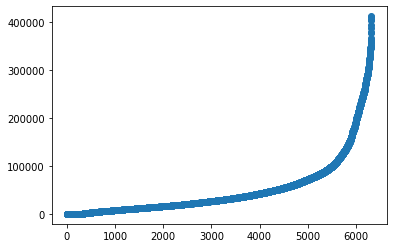

In [4]:
from matplotlib import pyplot as plt
import sklearn.cluster

plt.plot(np.arange(1, len(eigenvals)+1, 1), eigenvals, 'o')